In [1]:
from scoredriven import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

/Users/giuseppe.martucci/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def download_stock_data(ticker, start_date, end_date):
    # Download data from Yahoo Finance
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def calculate_volatility(stock_data, column='Adj Close', window=30):
    # Calculate daily returns
    stock_data['Daily_Return'] = stock_data[column].pct_change()

    # Calculate rolling volatility (standard deviation of returns)
    stock_data['Volatility'] = stock_data['Daily_Return'].rolling(window=window).std() * np.sqrt(252)  # Annualized

    return stock_data

# Example usage
ticker = "AAPL"  # Apple Inc.
start_date = "2020-01-01"
end_date = "2024-01-01"

# Download and calculate
stock_data = download_stock_data(ticker, start_date, end_date)
stock_data_with_volatility = calculate_volatility(stock_data)



[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

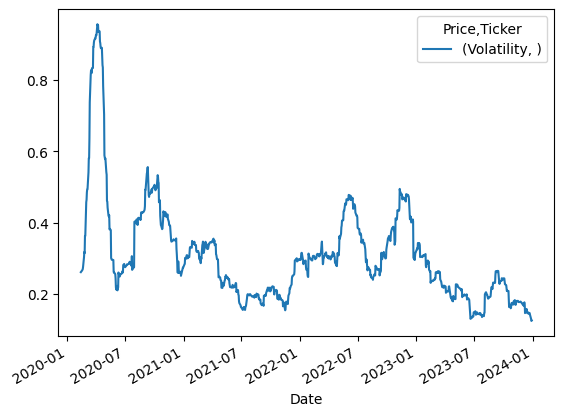

In [3]:
stock_data_with_volatility[['Volatility']].plot()


In [4]:
saving = False #True if you want to save the results

series = stock_data_with_volatility[['Volatility']]
train_size=200
test_size=8
end_train = 100 + train_size
end_test = end_train + test_size
train_set = series.iloc[100:end_train]
test_set = series.iloc[end_train:end_test]


train = train_set.values
test = test_set.values

In [5]:
def train_predict_univariate_scoredriven(series, target, train_size=200, test_size=8, initial_params=None):
    """
    Trains and predicts using the UDCS_t_Model class.
    
    Parameters:
    - series: DataFrame containing the data series
    - target: The column name of the target series
    - train_size: Number of observations to use for training
    - test_size: Number of observations to use for testing
    - initial_params: Initial parameters for the UDCS_t_Model [omega, phi, k, varsigma, nu]
    
    Returns:
    - preds: List of DataFrames with test and predicted values for each test set
    """
    # Extract the target series
    series = series[target]
    max_start_index = len(series) - train_size - test_size + 1
    preds = []
    
    # Use provided initial parameters or set defaults
    if initial_params is None:
        initial_params = [0.0, 0.0, 0.0, 1.0, 3.0]  # Default values for omega, phi, k, varsigma, nu

    for start in range(0, max_start_index, test_size):
        print(f"Training from index {start} to {start + train_size}")
        
        # Split into train and test sets
        end_train = start + train_size
        end_test = end_train + test_size
        train_set = series.iloc[start:end_train]
        test_set = series.iloc[end_train:end_test]

        # Train the model
        train = train_set.values
        test = test_set.values
        
        model = UDCS_t_Model(*initial_params)
        est = model.fit(train)

        # Extract optimized parameters
        optimized_params = est['theta']

        # Predict on the test set
        predictions = model.predict(test, future_steps=test_size)
        
        # Create a DataFrame with actual and predicted values
        test_series = pd.Series(test, name='test')
        pred_series = pd.Series(predictions.flatten(), name='pred')
        df = pd.concat([test_series.reset_index(drop=True), pred_series], axis=1)
        preds.append(df)

    return preds


In [6]:
series = series.dropna()

Training from index 0 to 200
Training from index 50 to 250
Training from index 100 to 300
Training from index 150 to 350
Training from index 200 to 400
Training from index 250 to 450
Training from index 300 to 500
Training from index 350 to 550
Training from index 400 to 600
Training from index 450 to 650
Training from index 500 to 700
Training from index 550 to 750
Training from index 600 to 800
Training from index 650 to 850
Training from index 700 to 900
Test 1:
        test      pred
0   0.352172  0.254403
1   0.354111  0.236646
2   0.352585  0.281161
3   0.352032  0.285914
4   0.351085  0.262158
5   0.351378  0.255410
6   0.351350  0.226213
7   0.356449  0.232462
8   0.326966  0.251546
9   0.312457  0.252111
10  0.260508  0.259965
11  0.292285  0.219698
12  0.291320  0.182245
13  0.271048  0.182613
14  0.259774  0.274746
15  0.261194  0.281863
16  0.262369  0.249024
17  0.263582  0.261874
18  0.251967  0.253958
19  0.268064  0.222238
20  0.272885  0.220729
21  0.275000  0.197871
2

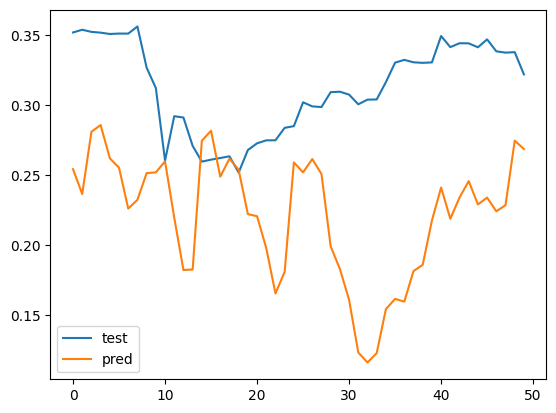

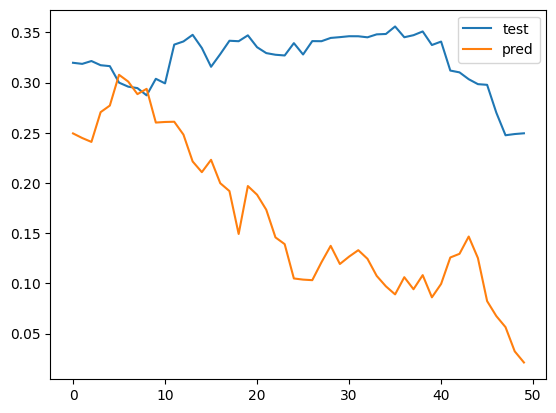

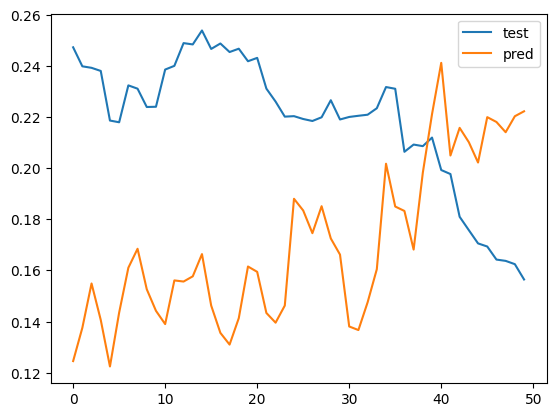

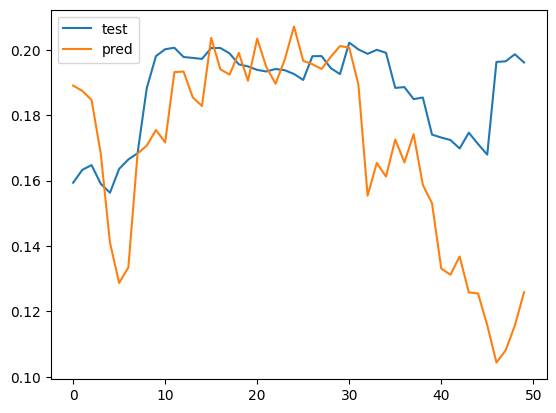

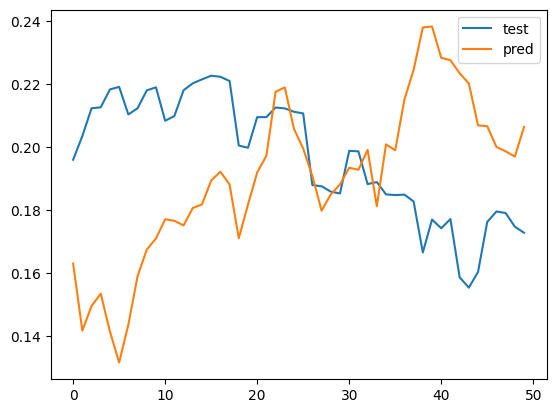

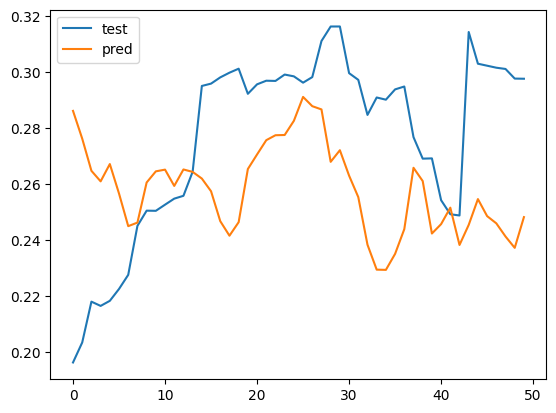

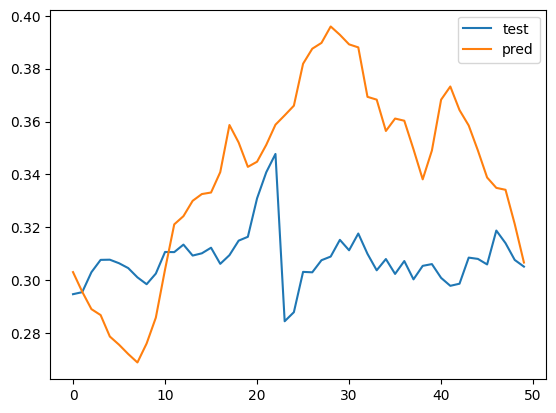

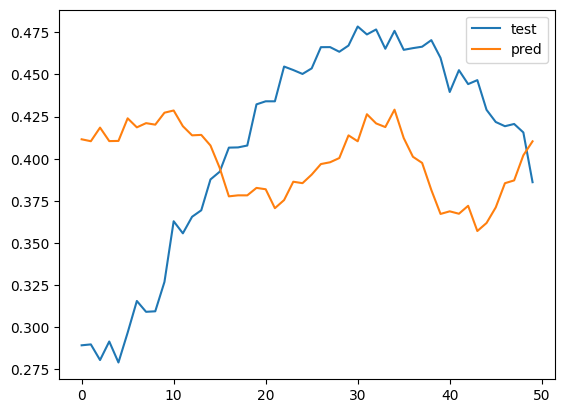

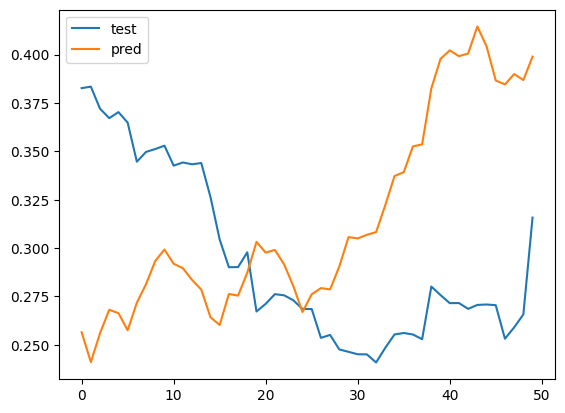

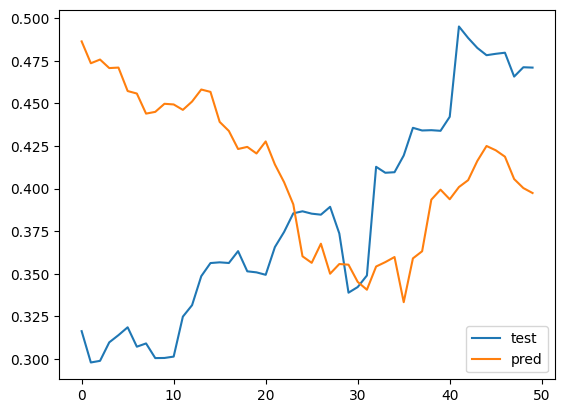

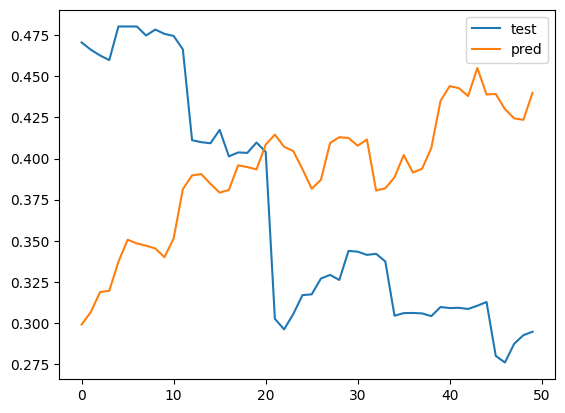

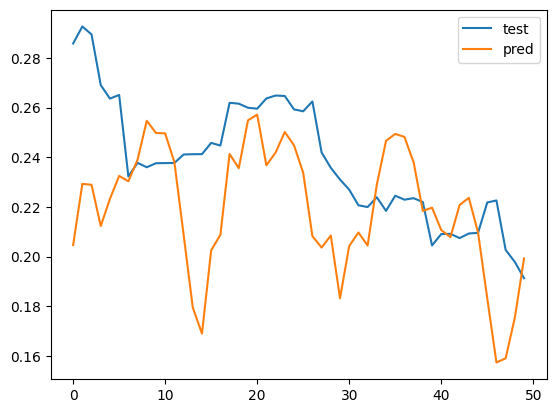

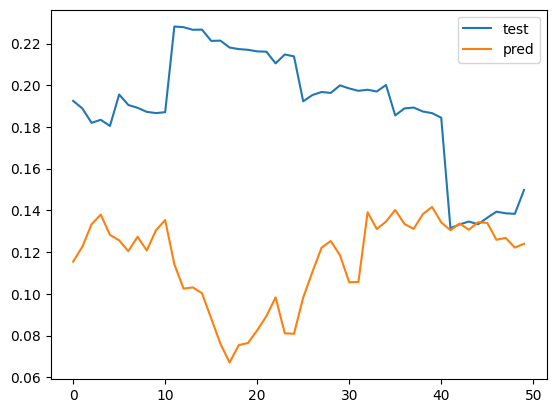

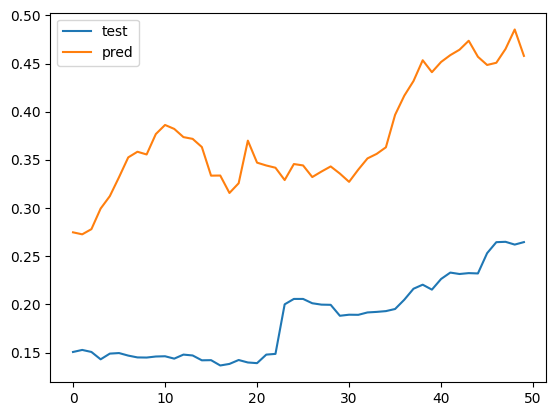

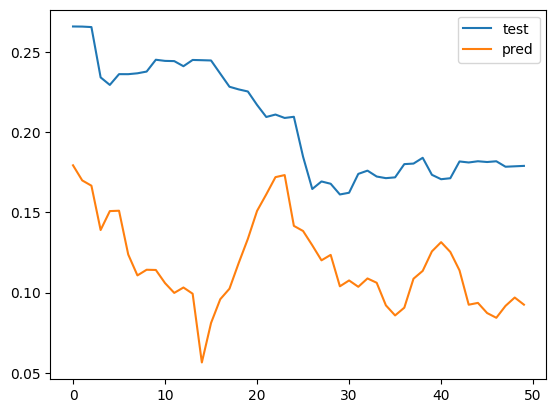

In [7]:
# Assuming `df` is a DataFrame with a column 'price'
initial_params = [0.1, 0.8, 0.5, 1.0, 5.0]  # Example parameters for omega, phi, k, varsigma, nu
results = train_predict_univariate_scoredriven(series, target='Volatility', train_size=200, test_size=50, initial_params=initial_params)

# To visualize results
for i, res in enumerate(results):
    print(f"Test {i + 1}:")
    print(res)
    res.plot()

In [11]:
final_results = pd.concat(results)

In [ ]:
if saving:
    final_results[['test','pred']].to_csv('./vol_scoredriven.csv')

Optimized Parameters: [2.67273927e-01 9.88942558e-01 1.59054037e+00 2.25758364e-04
 8.42144661e+00]


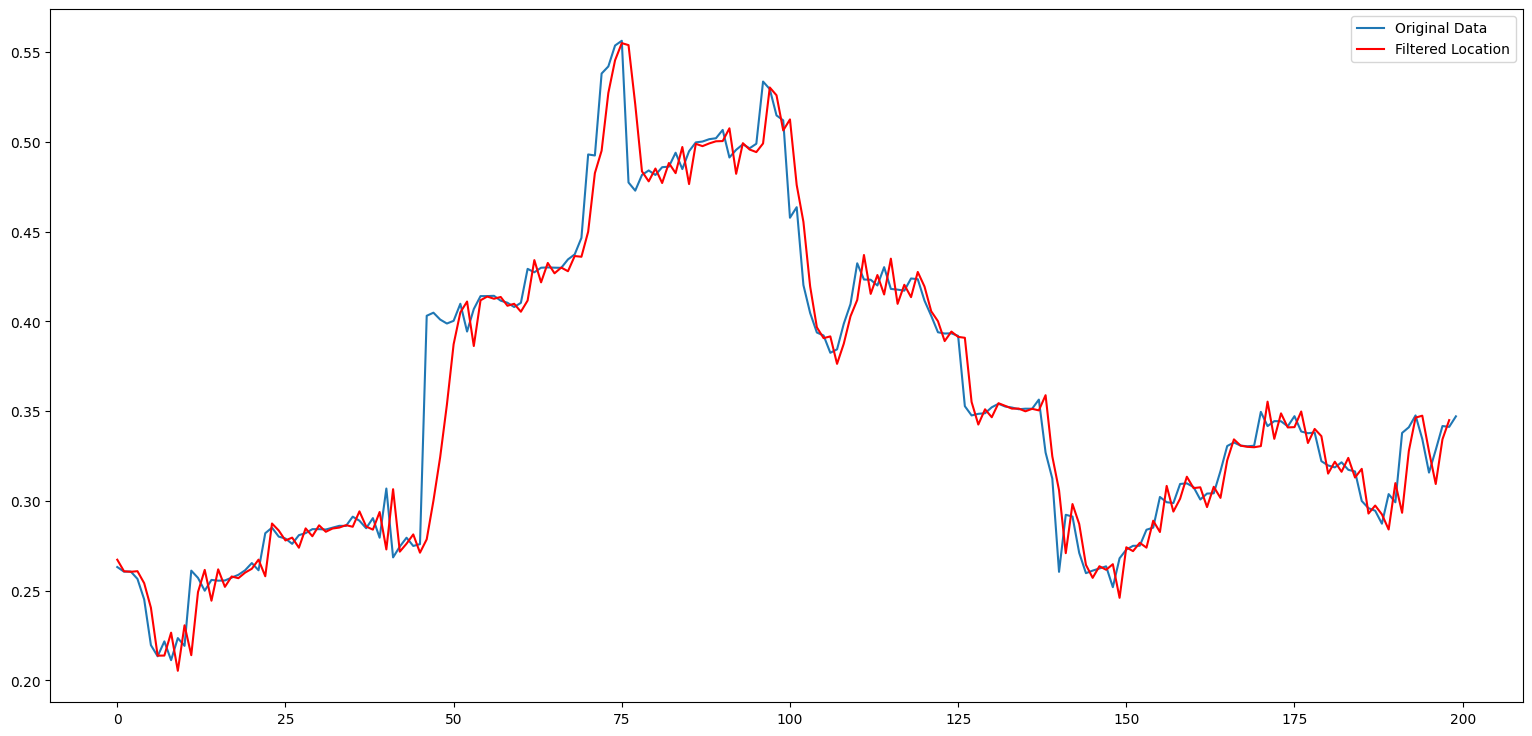

In [13]:
import matplotlib.pyplot as plt

# Initialize parameters
omega = 0
phi = 0.8  # 6-7
k = 0.8
varsigma = 1
nu = 8

# Create a list of the initial parameters
theta = [omega, phi, k, varsigma, nu]

# Create an instance of the UDCS_t_Model class
model = UDCS_t_Model(*theta)

# Estimate model parameters (fit the model)
est = model.fit(train)  # Use your train dataset here

# Extract the optimized parameters
theta_list = est['theta']
print("Optimized Parameters:", theta_list)

# Apply the filter to the train data
filtered = model.filter(train)  # Filtered dynamic location from the model

# Plot the data and the filtered dynamic location
plt.figure(figsize=(19, 9))
plt.plot(train, label='Original Data')
plt.plot(filtered['Dynamic_Location'], color='red', label='Filtered Location')
plt.legend()
plt.show()


array([[<Axes: title={'center': '0'}>]], dtype=object)

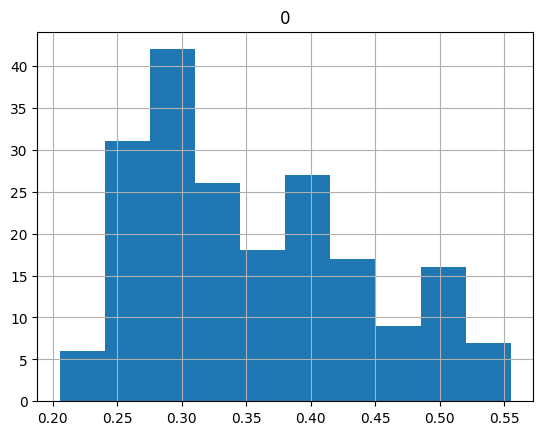

In [19]:
pd.DataFrame(filtered['Dynamic_Location']).hist(bins = 10)